#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [6]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
  N = X.shape[0]
  w = np.array(w)
  loss_sum = np.sum(np.log(1 + np.exp(-y * (X @ w + w0))))
  l1_penalty = gamma * np.sum(np.abs(w))
  l2_penalty = beta * np.sum(w ** 2)
  return (loss_sum / N) + l1_penalty + l2_penalty

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [7]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    N = X.shape[0]
    y = np.array(y)
    w = np.array(w)
    buff = (1 + np.exp(y * (X @ w + w0)))
    grad_w = - (X.T @ (y / buff)) / N + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = - np.sum(y / buff) / N
    return grad_w, grad_w0

In [8]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
print(grad_w)
print(grad_w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]
-0.20782319347690742


####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [10]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge

        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []


    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        self.w0 = 0

        for i in range(self.max_iter):

            random_index = np.random.randint(0, X.shape[0])
            xi = X[random_index, :].reshape(1, -1)
            yi = y[random_index]

            grad_w, grad_w0 = get_grad(xi, yi, self.w, self.w0, self.gamma, self.beta)

            self.w = self.w - self.lr * grad_w
            self.w0 = self.w0 - self.lr * grad_w0

            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)


    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X

        '''
        predictions = (X @ self.w + self.w0) >= 0
        return predictions.astype(int)


    def predict_proba(self, X):
        '''
        Function that estimates probabilities

        '''
        probabilities = 1 / (1 + np.exp(-(X @ self.w + self.w0)))
        return probabilities

In [11]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [12]:
def plot_decision_boundary(model, X, y):

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary of Logistic Regression')
    plt.show()

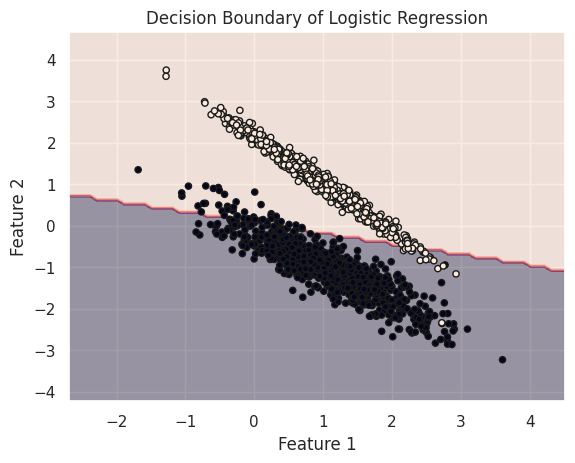

In [13]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [14]:
def plot_loss_history(model):
    plt.plot(model.loss_history)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss History of Logistic Regression')
    plt.show()


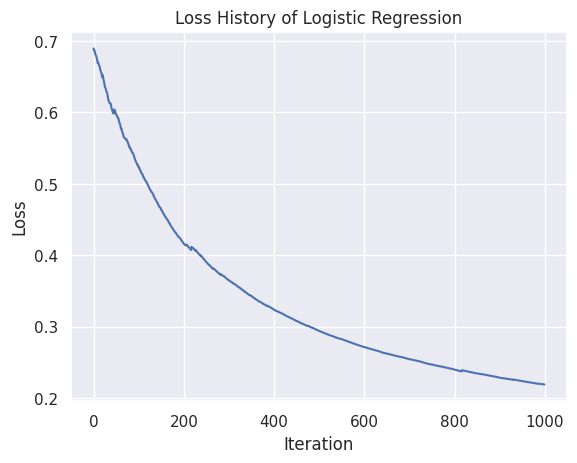

In [15]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10, 100]
for kernel in kernels:
  for C in C_values:
    model = SVC(kernel=kernel, C=C)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Kernel: {kernel}, C: {C}")
    print(f"Acc: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 20)

Kernel: linear, C: 0.1
Acc: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9973
F1-Score: 0.9971
--------------------
Kernel: linear, C: 1
Acc: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9973
F1-Score: 0.9971
--------------------
Kernel: linear, C: 10
Acc: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9973
F1-Score: 0.9971
--------------------
Kernel: linear, C: 100
Acc: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9973
F1-Score: 0.9971
--------------------
Kernel: poly, C: 0.1
Acc: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9973
F1-Score: 0.9971
--------------------
Kernel: poly, C: 1
Acc: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9973
F1-Score: 0.9971
--------------------
Kernel: poly, C: 10
Acc: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9973
F1-Score: 0.9971
--------------------
Kernel: poly, C: 100
Acc: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9973
F1-Score: 0.9971
--------------------
Kernel: rbf, C: 0.1
Acc: 0.9972
Precis

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [17]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
      self.n_neighbors = n_neighbors
      self.metric = metric
      self.X_train = None
      self.y_train = None

    def fit(self, X, y):
      self.X_train = X
      self.y_train = y

    def predict(self, X):
      predicted_labels = []
      for x in X:
        distances = [np.sqrt(np.sum((x - x_train)**2)) if self.metric == 'euclidean' else 0 for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.n_neighbors]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        unique_labels, label_counts = np.unique(k_nearest_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(label_counts)]

        predicted_labels.append(predicted_label)
      return np.array(predicted_labels)

    def predict_proba(self, X):
      probabilities = []
      for x in X:
        distances = [np.sqrt(np.sum((x - x_train)**2)) if self.metric == 'euclidean' else 0 for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.n_neighbors]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        unique_labels, label_counts = np.unique(k_nearest_labels, return_counts=True)
        probs = label_counts / self.n_neighbors

        all_unique_labels = np.unique(self.y_train)
        full_probs = np.zeros(len(all_unique_labels))
        for i, label in enumerate(all_unique_labels):
            if label in unique_labels:
                full_probs[i] = probs[np.where(unique_labels == label)[0][0]]

        probabilities.append(full_probs)
      return np.array(probabilities)


In [18]:
knn = KNNClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
ROC AUC: 0.9973
F1 Score: 0.9971


In [19]:
a = knn.predict_proba(X_test)
print(a)

[[1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.2 0.8]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]

## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [4]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')
print(df.head())

   Id  Category  Pixel000  Pixel001  Pixel002  Pixel003  Pixel004  Pixel005  \
0   0         2         0         0         0         0         0         0   
1   1         9         0         0         0         0         0         0   
2   2         6         0         0         0         0         0         0   
3   3         0         0         0         0         1         2         0   
4   4         3         0         0         0         0         0         0   

   Pixel006  Pixel007  ...  Pixel774  Pixel775  Pixel776  Pixel777  Pixel778  \
0         0         0  ...         0         0         0         0         0   
1         0         0  ...         0         0         0         0         0   
2         0         5  ...         0         0         0        30        43   
3         0         0  ...         3         0         0         0         0   
4         0         0  ...         0         0         0         0         0   

   Pixel779  Pixel780  Pixel781  Pixel782  P

In [20]:
X = df.drop('Category', axis=1)
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=50000, random_state=42)
print(X_train.head(), X_test.head(), y_train.head(), y_test.head())

          Id  Pixel000  Pixel001  Pixel002  Pixel003  Pixel004  Pixel005  \
11210  11210         0         0         0         0         0         0   
17024  17024         0         0         0         0         0         0   
43389  43389         0         0         0         0         0         5   
30050  30050         0         0         0         0         0         0   
34665  34665         0         0         0         0         0         0   

       Pixel006  Pixel007  Pixel008  ...  Pixel774  Pixel775  Pixel776  \
11210         0         0         0  ...       135         0         0   
17024         0         0         0  ...         0         0         0   
43389         0         0         0  ...         0         0         0   
30050         0         0         0  ...         0         0         0   
34665         0        59       155  ...         0         0         1   

       Pixel777  Pixel778  Pixel779  Pixel780  Pixel781  Pixel782  Pixel783  
11210         0     

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

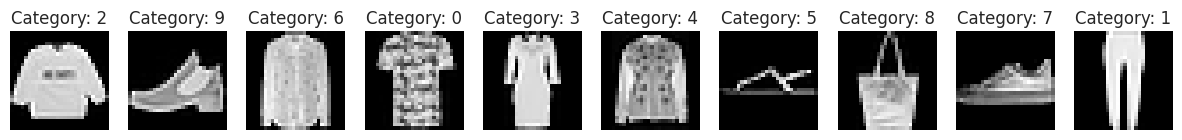

In [21]:
def visualizeDF(data):
  unique_cats = data['Category'].unique()
  fig, axes = plt.subplots(1, len(unique_cats), figsize=(15, 5))
  for i, category in enumerate(unique_cats):
      image_data = data[data['Category'] == category].iloc[0, 2:].values

      image = image_data.reshape(28, 28)

      axes[i].imshow(image, cmap='gray')
      axes[i].set_title(f'Category: {category}')
      axes[i].axis('off')
  plt.show()

visualizeDF(df)

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X_train_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)

X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

print(X_train_standard)
print(X_train_minmax)

[[-1.08347323 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 [-0.74771055 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 [ 0.77488714 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 ...
 [-1.68119316 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 [-0.81868618 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 [ 1.52755225 -0.00941399 -0.02213614 ... -0.10107578 -0.09175096
  -0.03167199]]
[[0.18683956 0.         0.         ... 0.         0.         0.        ]
 [0.28374279 0.         0.         ... 0.         0.         0.        ]
 [0.72317411 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01433381 0.         0.         ... 0.         0.         0.        ]
 [0.26325878 0.         0.         ... 0.         0.         0.        ]
 [0.94039801 0.         0.         ... 0.00392157 0.         0.        ]]


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

Для модели knn я выбрал два гиперпараметра: количество соседей, обрабатываемых алгоритмом, и метрику алгоритма.

Первое - очевидный параметр, который напрямую влияет на работу алгоритма (буквально упоминается в названии), и его настройка важна для разных данных, т.к. если для каких-то данных определённое значение будет подходить хорошо, то на других данных оно может быть слишком большим (сравнивать элемент с слишком дальними соседями) или маленьким.

Второе - то, что под капотом алгоритма используется для оценки. Вполне логично, что к разным данным нужны разные подходы в плане оценивания.

Обычно для knn берут k равным 5, поэтому я решил выбрать значения 3, 5, 7, как достаточно отличающиеся, но вокруг 5 (пробовал 8 значений пихнуть, считалось больше 2.5 часов, решил забить, так-то оно с 3 посчиталось за 2, но здесь скорее metric='manhattan' виновата, euclidean у меня отдельно считалась за 1 минуту, а manhattan за 10)


In [24]:
knn_params = {
    'n_neighbors': [3, 5, 7],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
knn_grid.fit(X_train_standard, y_train)

knn_pred = knn_grid.predict(X_test_standard)
knn_accuracy = accuracy_score(y_test, knn_pred)

print(f"KNN Accuracy: {knn_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


KNN Accuracy: 0.8564


Для LogReg я выбрал также 2 параметра:

C - очевидный параметр, который влияет на регуляризацию модели (меньше параметр - больше регуляризация - проще модель и меньше переобучение; больше параметр - меньше регуляризация - сложнее модель, но больше переобучение, но его нужно подбирать, т.к. слишком простая модель будет очень неточной).
Значения идут по логарифмической шкале, т.к. именно в таком виде между ними действительно есть практическая разница.

Вариативность штрафа в модели (тут все варианты кроме полного отсутствия (с простыми пояснениями): l1 - удаляет избыточные признаки, l2 - логика та же, но менее склонна к переобучению за счёт квадратичного штрафного члена, elastic net - использует и l1, и l2, что лучше выявляет коррелированные признаки чем l1 или l2 по отдельности)

In [29]:
logit_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet']
}

logit_grid = GridSearchCV(LogisticRegression(max_iter=1000), logit_params, cv=5, scoring='accuracy')
logit_grid.fit(X_train_standard, y_train)

logit_pred = logit_grid.predict(X_test_standard)
logit_accuracy = accuracy_score(y_test, logit_pred)

print(f"Logistic Regression Accuracy: {logit_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression Accuracy: 0.8551


У LogReg (0.8551) получилась accuracy чуть хуже чем у KNN (0.8564), что логично, так как knn лучше понимает нелинейные зависимости (а картинка переведённая в вектор явно имеет нелинейные зависимости) и лучше показывает себя на маленьких датасетах (50000 тренировочная и 10000 тестовая выборки - маленький датасет). (Хотя у LogReg и было больше вариантов гиперпараметров, возможно стоило попробовать какие-нибудь ещё параметры у обеих моделей, однако это было бы слишком затратно по времени (не могу сказать точно, сколько считался LogReg, т.к. в процессе было потеряно соединение со средой и время мне уже не показывало, но это заняло порядка 3 часов))

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Ответ: модель не сойдётся к осмысленному решению.

Во-первых: logreg не сможет выстроить гиперплоскость, которая разделяет объекты, т.к. у объектов идентичные признаки, т.е. разделять буквально нечего.

Во-вторых: SGD не сможет адекватно обновлять веса, т.к. градиент для любого маленького набора данных из выборки будет вычисляться по бесполезной для разделения информации.

По итогу модель, обученная на таких данных будет принимать практически случайное решение.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.